# CO2 source: CarbonTracker model output, 129 grids as the same location of WDCGG, 2000-2017
# CO2 analysis method: NOAA

In [7]:
import numpy as np
import scipy as sp
import pandas as pd
from os import listdir
from os.path import isfile, join
import ccg_filter
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
%matplotlib inline

font = {'weight' : 'bold', 'size' : 14}
matplotlib.rc('font', **font)

# Define functions 

In [8]:
def decimalDate_ymd (year, month, day=15):
    """ Convert a date to a fractional year. """
    pd_date = pd.to_datetime(year*10000 + month*100 + day, format='%Y%m%d')
    
    return pd_date.dt.year + pd_date.dt.dayofyear / [366 if x else 365 for x in pd_date.dt.is_leap_year]

In [9]:
def decimalDate_datetime (datetime):
    """ Convert a date to a fractional year. """
    
    return datetime.dt.year + datetime.dt.dayofyear / [366 if x else 365 for x in datetime.dt.is_leap_year]

In [10]:
def grid_area (resolution=0.5):
    """Calculate the area of each grid cell for a user-provided
    grid cell resolution. Area is in square meters, but resolution
    is given in decimal degrees."""
    # Calculations needs to be in radians
    lats = np.deg2rad(np.arange(-90,90+resolution, resolution))
    r_sq = 6371000**2
    n_lats = int(360./resolution) 
    area = r_sq*np.ones(n_lats)[:, None]*np.deg2rad(resolution)*(
                np.sin(lats[1:]) - np.sin(lats[:-1]))
    return area.T

In [11]:
IN_PATH = "D:\\MyData\\jupter\\icos\\ctracker_model\\"
OUT_PATH = "D:\\MyData\\jupter\\icos\\ctracker_model\\"

# Organize raw and calculated co2 from 185 stations into one dataframe, respectively

In [6]:
# read metadata and list the files/output from fit_filter_noaa.ipynb
df_meta = pd.read_csv(IN_PATH+"df_meta_wdcgg.csv", encoding = "ISO-8859-1")
csvfiles = listdir(IN_PATH+"output129\\")
df_meta["monthes"] = 0
df_meta["flag"] = 0

# orginaze full monthly time series from 2000 to 2017
df_fullperiod = pd.DataFrame()
df_fullperiod["date"] = pd.date_range(start='2000-01-01', end='2017-12-31', freq="M")
df_fullperiod.date = df_fullperiod.date.apply(lambda dt: dt.replace(day=15))
df_fullperiod['decimalyear'] = decimalDate_ymd( df_fullperiod.date.dt.year,  df_fullperiod.date.dt.month, 15)

# combine the raw and calculated co2 from 185 csv files into a single csv file with lon and lat
df_co2_raw = pd.DataFrame()
df_co2_cal = pd.DataFrame()
df_co2rate_cal = pd.DataFrame()
    
for i in range(df_meta.shape[0]):
#     i = 0
    # using csv file name to find right lon and lat from metadata (df_meta_selected_ctracker_update.csv)
    pre_filename = df_meta.FILENAME[i].split(".")[0]
    matching = [s for s in csvfiles if pre_filename in s]
    
    if len(matching) != 1:
        print(f"Warming: the file {pre_filename} is excluded in this analysis, due to less data")
        continue
    df_meta.at[i,"flag"]= 1
    
    # read csv data, and fill in full period (2000-2017)
    dat = pd.read_csv(IN_PATH+"output129\\"+ matching[0])
    dat.date = pd.to_datetime(dat.date)
    df_merge = pd.merge(df_fullperiod,dat, how="left", on="date")
    
    df_meta.at[i,"monthes"]= dat.shape[0]
    # combine sitecode, lon, lat, filename, and 216 months co2 as one row, and concatanate them into dataframe
    record_raw = pd.concat([df_meta.iloc[i,[2,6,5,1]],df_merge.co2])
    record_cal = pd.concat([df_meta.iloc[i,[2,6,5,1]],df_merge.polypart + df_merge.harmpart + df_merge.resid_smooth])
    df_co2_raw = pd.concat([df_co2_raw, record_raw], axis=1)
    df_co2_cal = pd.concat([df_co2_cal, record_cal], axis=1)
    
    record_cal = pd.concat([df_meta.iloc[i,[2,6,5,1]],df_merge.growth_rate])
    df_co2rate_cal = pd.concat([df_co2rate_cal, record_cal], axis=1)
    
print(f"Remain {df_co2_cal.shape[1]} stations data for analysis")

# save files
df_co2_raw = df_co2_raw.T.reset_index(drop=True)       
df_co2_cal = df_co2_cal.T.reset_index(drop=True)
df_co2rate_cal = df_co2rate_cal.T.reset_index(drop=True)

df_co2_raw.columns = ['sitename', 'lon', 'lat', 'file'] + [d.strftime('%Y-%m-%d') for d in df_fullperiod["date"]]
df_co2_cal.columns = ['sitename', 'lon', 'lat', 'file'] + [d.strftime('%Y-%m-%d') for d in df_fullperiod["date"]]
df_co2rate_cal.columns = ['sitename', 'lon', 'lat', 'file'] + [d.strftime('%Y-%m-%d') for d in df_fullperiod["date"]]

df_co2_raw.to_csv(OUT_PATH + "df_co2_raw_ctracker_model_129p.csv", header=True,index=False, na_rep= "NaN")
df_co2_cal.to_csv(OUT_PATH + "df_co2_cal_ctracker_model_129p.csv", header=True,index=False, na_rep= "NaN")
df_co2rate_cal.to_csv(OUT_PATH + "df_co2rate_cal_ctracker_model_129p.csv", header=True,index=False, na_rep= "NaN")

df_meta.to_csv(OUT_PATH +"df_meta_wdcgg_update.csv", header=True,index=False, na_rep= "NaN")

Remain 129 stations data for analysis


# Calculate zonal and global co2 average over each 30 degree latitudinal band

In [7]:
df_co2_raw = pd.read_csv(IN_PATH + "df_co2_raw_ctracker_model_129p.csv")
df_co2_cal = pd.read_csv(IN_PATH + "df_co2_cal_ctracker_model_129p.csv")


zonal_deg = 30
df_area = pd.DataFrame(grid_area(0.5))
area_lat = df_area.iloc[:,0]
area_zonal = area_lat.groupby(np.arange(len(area_lat))//(zonal_deg/0.5)).sum()

global_weight = area_zonal/area_zonal.sum()
NH_weight = area_zonal[:len(area_zonal)/2-1] /(area_zonal.sum()/2)
SH_weight = area_zonal[len(area_zonal)/2:] /(area_zonal.sum()/2)

lat_range = range(-90,90,zonal_deg)

df_zonal_raw = pd.DataFrame()
df_zonal_cal = pd.DataFrame() 
for i in lat_range:

    lat_id = (i < df_co2_raw.lat) & (df_co2_raw.lat<= i+zonal_deg)
    temp_raw = df_co2_raw.loc[lat_id,:]
    temp_cal = df_co2_cal.loc[lat_id,:]
    
    df_zonal_raw = pd.concat([df_zonal_raw,  pd.DataFrame(temp_raw.iloc[:,4:].mean()).T] )
    df_zonal_cal = pd.concat([df_zonal_cal,  pd.DataFrame(temp_cal.iloc[:,4:].mean()).T] )

df_zonal_raw["lat"] = [str(i) + "_" + str(i+zonal_deg)  for i in lat_range]
df_zonal_cal["lat"] = [str(i) + "_" + str(i+zonal_deg)  for i in lat_range]
cols_new = df_zonal_raw.columns.to_list()
cols_new = cols_new[-1:] + cols_new[:-1]
df_zonal_raw = df_zonal_raw.loc[:,cols_new]
df_zonal_cal = df_zonal_cal.loc[:,cols_new]
df_zonal_raw = df_zonal_raw.iloc[::-1] 
df_zonal_cal = df_zonal_cal.iloc[::-1] 
df_zonal_raw = df_zonal_raw.set_index(["lat"])
df_zonal_cal = df_zonal_cal.set_index(["lat"])

global_weight = global_weight.set_axis(df_zonal_raw.index)
NH_weight = NH_weight.set_axis(df_zonal_raw.index[:3])
SH_weight = SH_weight.set_axis(df_zonal_raw.index[3:])

# raw global weighted average
global_co2_raw = df_zonal_raw.mul(global_weight, axis = 0).sum(min_count=1)
NH_co2_raw = df_zonal_raw.iloc[:3,:].mul(NH_weight, axis = 0).sum(min_count=1)
SH_co2_raw = df_zonal_raw.iloc[3:,:].mul(SH_weight, axis = 0).sum(min_count=1)

# calculated global weighted average
global_co2_cal = df_zonal_cal.mul(global_weight, axis = 0).sum(min_count=1)
NH_co2_cal = df_zonal_cal.iloc[:3,:].mul(NH_weight, axis = 0).sum(min_count=1)
SH_co2_cal = df_zonal_cal.iloc[3:,:].mul(SH_weight, axis = 0).sum(min_count=1)

# calculate annual co2
datetime = pd.to_datetime(pd.DataFrame(global_co2_raw.index)[0],format='%Y-%m-%d')
co2_monthly = pd.concat([global_co2_raw,NH_co2_raw,SH_co2_raw,global_co2_cal,NH_co2_cal,SH_co2_cal],axis=1)
co2_monthly.columns = ["global_raw","NH_raw","SH_raw","global_cal","NH_cal","SH_cal"]
co2_monthly["year"] = datetime.dt.year.tolist()
co2_annual = co2_monthly.groupby(["year"]).mean().T
co2_annual.to_csv(OUT_PATH +"df_annual_global_NH_SH_ctracker_model_129p.csv", header=True,index=True, na_rep= "NaN")
co2_annual

year,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
global_raw,369.798782,371.098837,373.182047,375.802589,377.671834,379.822405,381.986474,383.762454,385.804404,387.251758,389.541224,391.578419,393.642540,396.410330,398.374418,400.494233,403.598268,406.210554
NH_raw,371.684463,372.931449,375.019226,377.834195,379.617989,381.897575,384.336686,385.897000,388.103539,389.452087,391.983457,394.167612,396.184899,398.938281,400.862778,403.021693,406.068505,408.996658
SH_raw,367.913101,369.266226,371.344867,373.770983,375.725680,377.747236,379.636262,381.627908,383.505270,385.051429,387.098990,388.989226,391.100182,393.882378,395.886058,397.966773,401.128031,403.424449
global_cal,369.797375,371.103035,373.185679,375.798145,377.675682,379.819098,381.987853,383.768383,385.797918,387.255929,389.542287,391.572740,393.651535,396.405056,398.385385,400.487330,403.598771,406.200220
NH_cal,371.685197,372.937590,375.025477,377.826480,379.623895,381.892592,384.339183,385.904591,388.095351,389.457278,391.989083,394.157050,396.199849,398.928868,400.884155,403.004708,406.076119,408.975676
SH_cal,367.909553,369.268480,371.345881,373.769811,375.727469,377.745605,379.636522,381.632176,383.500485,385.054580,387.095492,388.988429,391.103221,393.881245,395.886614,397.969952,401.121424,403.424764


# Plot global, NH and SH area-weighted average CO2 concentration  

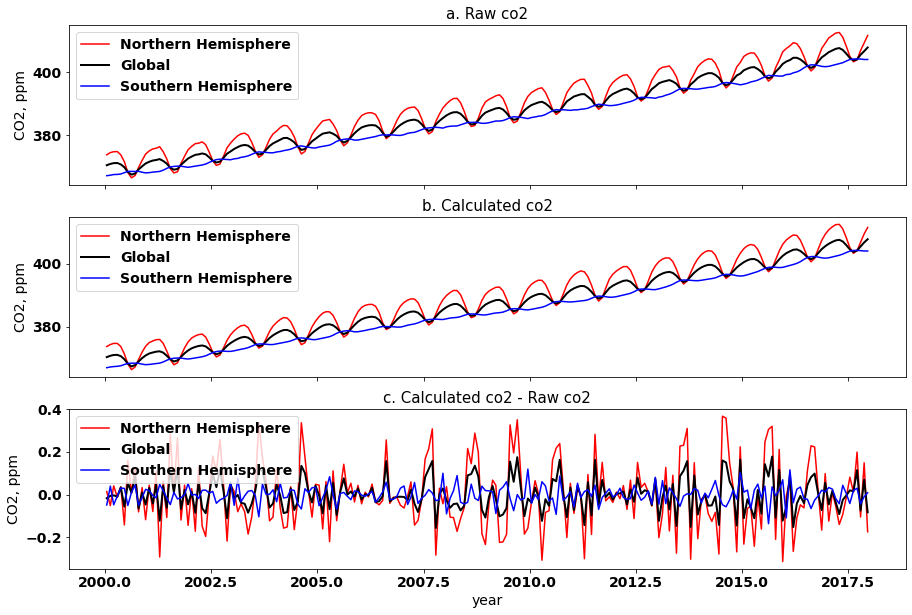

In [8]:
x_decimalyear = decimalDate_datetime(pd.to_datetime(pd.DataFrame(global_co2_raw.index)[0],format='%Y-%m-%d'))
fig,axis = plt.subplots(nrows=3,ncols=1,sharex=True, sharey=False, figsize = (15,10))
(ax1,ax2,ax3) = axis

ax1.plot(x_decimalyear,NH_co2_raw, 'r', label = "Northern Hemisphere")
ax1.plot(x_decimalyear,global_co2_raw, 'k', label = "Global", lw=2)
ax1.plot(x_decimalyear,SH_co2_raw,'b', label = "Southern Hemisphere")
ax1.set_ylabel("CO2, ppm")
ax1.legend()
ax1.set_title("a. Raw co2",fontsize=15)

ax2.plot(x_decimalyear,NH_co2_cal, 'r', label = "Northern Hemisphere")
ax2.plot(x_decimalyear,global_co2_cal, 'k', label = "Global", lw=2)
ax2.plot(x_decimalyear,SH_co2_cal,'b', label = "Southern Hemisphere")
ax2.set_ylabel("CO2, ppm")
ax2.legend()
ax2.set_title("b. Calculated co2",fontsize=15)

ax3.plot(x_decimalyear,NH_co2_cal - NH_co2_raw, 'r', label = "Northern Hemisphere")
ax3.plot(x_decimalyear,global_co2_cal - global_co2_raw, 'k', label = "Global", lw=2)
ax3.plot(x_decimalyear,SH_co2_cal - SH_co2_raw,'b', label = "Southern Hemisphere")
ax3.set_xlabel("year")
ax3.set_ylabel("CO2, ppm")
ax3.legend()
ax3.set_title("c. Calculated co2 - Raw co2",fontsize=15);

# Plot co2 zonal map 

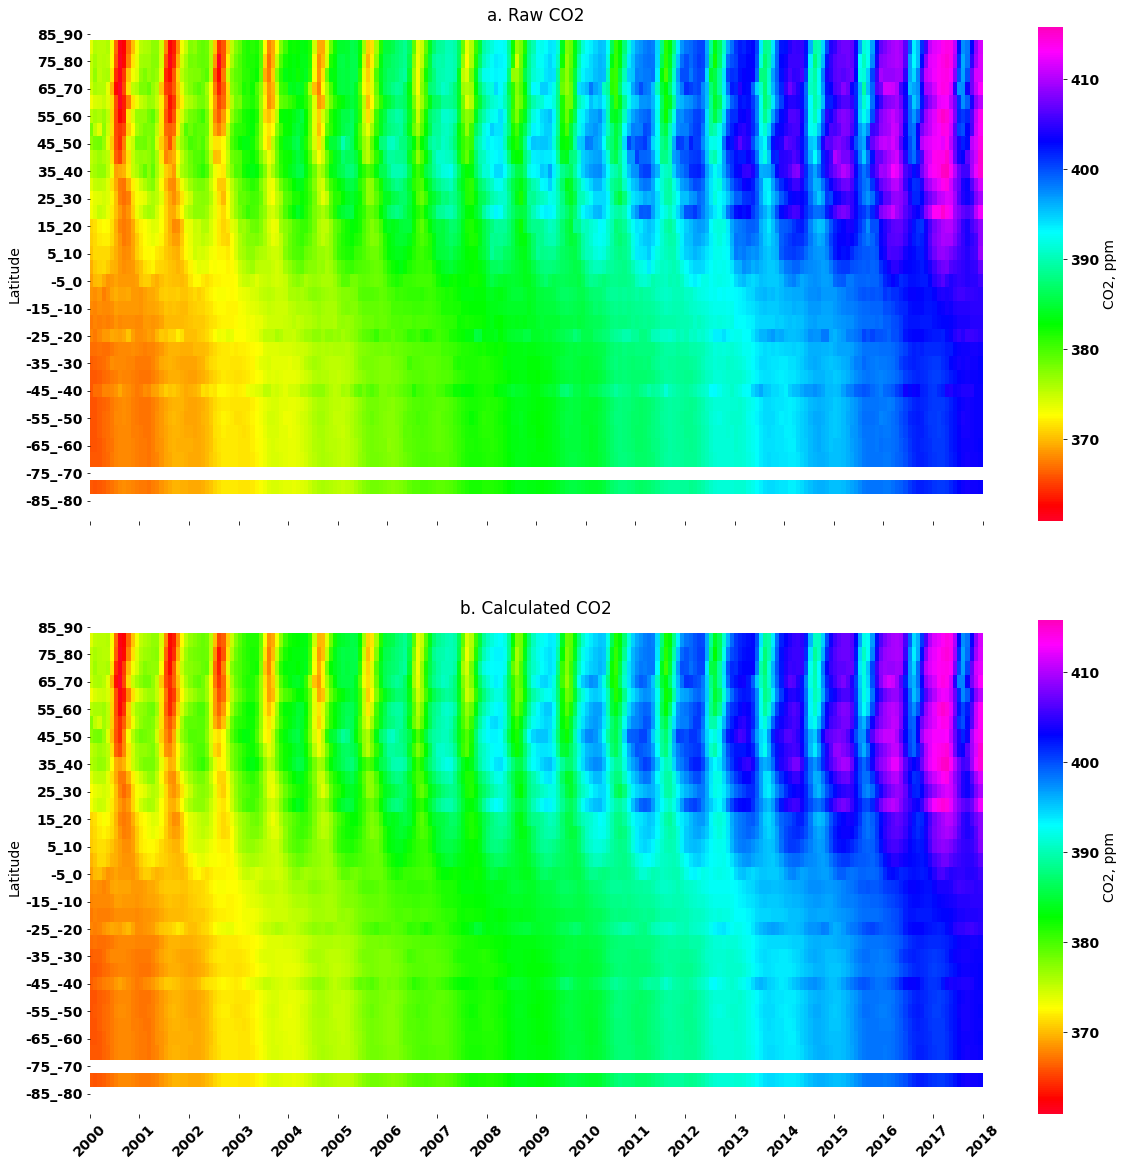

In [6]:
# Arrange dataframe for plot
df_co2_raw = pd.read_csv(IN_PATH + "df_co2_raw_ctracker_model_129p.csv")
df_co2_cal = pd.read_csv(IN_PATH + "df_co2_cal_ctracker_model_129p.csv")

zonal_deg = 5

lat_range = range(-90,90,zonal_deg)

df_zonal_raw = pd.DataFrame()
df_zonal_cal = pd.DataFrame() 
for i in lat_range:

    lat_id = (i < df_co2_raw.lat) & (df_co2_raw.lat<= i+zonal_deg)
    temp_raw = df_co2_raw.loc[lat_id,:]
    temp_cal = df_co2_cal.loc[lat_id,:]
    
    df_zonal_raw = pd.concat([df_zonal_raw,  pd.DataFrame(temp_raw.iloc[:,4:].mean()).T] )
    df_zonal_cal = pd.concat([df_zonal_cal,  pd.DataFrame(temp_cal.iloc[:,4:].mean()).T] )

df_zonal_raw["lat"] = [str(i) + "_" + str(i+zonal_deg)  for i in lat_range]
df_zonal_cal["lat"] = [str(i) + "_" + str(i+zonal_deg)  for i in lat_range]
cols_new = df_zonal_raw.columns.to_list()
cols_new = cols_new[-1:] + cols_new[:-1]
df_zonal_raw = df_zonal_raw.loc[:,cols_new]
df_zonal_cal = df_zonal_cal.loc[:,cols_new]
df_zonal_raw = df_zonal_raw.iloc[::-1] 
df_zonal_cal = df_zonal_cal.iloc[::-1] 
df_zonal_raw = df_zonal_raw.set_index(["lat"])
df_zonal_cal = df_zonal_cal.set_index(["lat"])

# plot
xticks = [i for i in range(0, df_zonal_raw.shape[1]+12, 12)]
xticklabels = [i for i in range(2000,2019)]

cmax = max(df_zonal_cal.max().max(), df_zonal_raw.max().max())
cmin = max(df_zonal_cal.min().min(), df_zonal_raw.min().min())

# sns.set(font_scale=1.4)

fig,axis = plt.subplots(nrows=2,ncols=1,sharex=True,sharey=True,figsize=[20,20])
(ax1,ax2) = axis
sns.heatmap(df_zonal_raw, cmap=plt.get_cmap("gist_rainbow"), ax=ax1, cbar_kws={'label': 'CO2, ppm'}, vmax=cmax,vmin=cmin)
ax1.set_ylabel("Latitude")
ax1.set_xticks(xticks)
ax1.set_xticklabels(xticklabels,rotation=45)
ax1.set_title("a. Raw CO2")

sns.heatmap(df_zonal_cal, cmap=plt.get_cmap("gist_rainbow"), ax=ax2, cbar_kws={'label': 'CO2, ppm'}, vmax=cmax,vmin=cmin)
ax2.set_ylabel("Latitude")
ax2.set_xticks(xticks) 
ax2.set_xticklabels(xticklabels,rotation=45)
ax2.set_title("b. Calculated CO2");

# Calculate zonal and global CO2 growth rate average over each 30 degree latitudinal band

In [13]:
df_co2rate_cal = pd.read_csv(IN_PATH + "df_co2rate_cal_ctracker_model_129p.csv")

zonal_deg = 30
df_area = pd.DataFrame(grid_area(0.5))
area_lat = df_area.iloc[:,0]
area_zonal = area_lat.groupby(np.arange(len(area_lat))//(zonal_deg/0.5)).sum()

global_weight = area_zonal/area_zonal.sum()
NH_weight = area_zonal[:len(area_zonal)/2-1] /(area_zonal.sum()/2)
SH_weight = area_zonal[len(area_zonal)/2:] /(area_zonal.sum()/2)

lat_range = range(-90,90,zonal_deg)

df_zonal_cal = pd.DataFrame() 
for i in lat_range:
    lat_id = (i < df_co2_raw.lat) & (df_co2_raw.lat<= i+zonal_deg)
    temp_cal = df_co2rate_cal.loc[lat_id,:]
    
    df_zonal_cal = pd.concat([df_zonal_cal,  pd.DataFrame(temp_cal.iloc[:,4:].mean()).T] )

df_zonal_cal["lat"] = [str(i) + "_" + str(i+zonal_deg)  for i in lat_range]
cols_new = df_zonal_cal.columns.to_list()
cols_new = cols_new[-1:] + cols_new[:-1]
df_zonal_cal = df_zonal_cal.loc[:,cols_new]
df_zonal_cal = df_zonal_cal.iloc[::-1] 
df_zonal_cal = df_zonal_cal.set_index(["lat"])

global_weight = global_weight.set_axis(df_zonal_cal.index)
NH_weight = NH_weight.set_axis(df_zonal_cal.index[:3])
SH_weight = SH_weight.set_axis(df_zonal_cal.index[3:])

# calculated global weighted average
global_co2rate_cal = df_zonal_cal.mul(global_weight, axis = 0).sum(min_count=1)
NH_co2rate_cal = df_zonal_cal.iloc[:3,:].mul(NH_weight, axis = 0).sum(min_count=1)
SH_co2rate_cal = df_zonal_cal.iloc[3:,:].mul(SH_weight, axis = 0).sum(min_count=1)

# calculate annual co2
datetime = pd.to_datetime(pd.DataFrame(global_co2rate_cal.index)[0],format='%Y-%m-%d')
co2rate_annual = pd.concat([global_co2rate_cal,NH_co2rate_cal,SH_co2rate_cal],axis=1)
co2rate_annual.columns = ["global_co2rate_cal","NH_co2rate_cal","SH_co2rate_cal"]
co2rate_annual["year"] = datetime.dt.year.tolist()
co2rate_annual.groupby(["year"]).mean().T

year,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
global_co2rate_cal,1.326528,1.613655,2.525239,2.399270,1.643302,2.530541,1.672685,2.162443,1.551239,1.752056,2.527378,1.660794,2.640627,2.506271,1.680844,2.728521,3.11757,2.175387
NH_co2rate_cal,1.441420,1.479960,2.655847,2.533069,1.570163,2.763447,1.751356,2.078578,1.591836,1.802329,2.807526,1.613178,2.706972,2.384600,1.751388,2.633948,3.34890,2.199976
SH_co2rate_cal,1.211635,1.747349,2.394631,2.265472,1.716440,2.297636,1.594013,2.246307,1.510642,1.701783,2.247230,1.708410,2.574282,2.627942,1.610300,2.823094,2.88624,2.150798


# Plot global, NH and SH area-weighted average CO2 growth rate

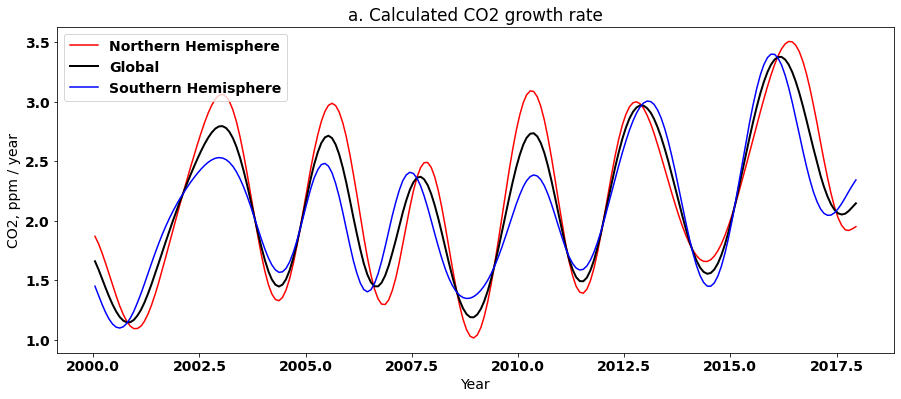

In [14]:
x_decimalyear = decimalDate_datetime(pd.to_datetime(pd.DataFrame(global_co2rate_cal.index)[0],format='%Y-%m-%d'))

fig = plt.figure( figsize = (15,6))
ax = plt.axes()

ax.plot(x_decimalyear,NH_co2rate_cal, 'r', label = "Northern Hemisphere")
ax.plot(x_decimalyear,global_co2rate_cal, 'k', label = "Global", lw=2)
ax.plot(x_decimalyear,SH_co2rate_cal,'b', label = "Southern Hemisphere")
ax.set_xlabel("Year")
ax.set_ylabel("CO2, ppm / year")
ax.legend()
ax.set_title("a. Calculated CO2 growth rate");


# Plot CO2 growth rate  zonal map

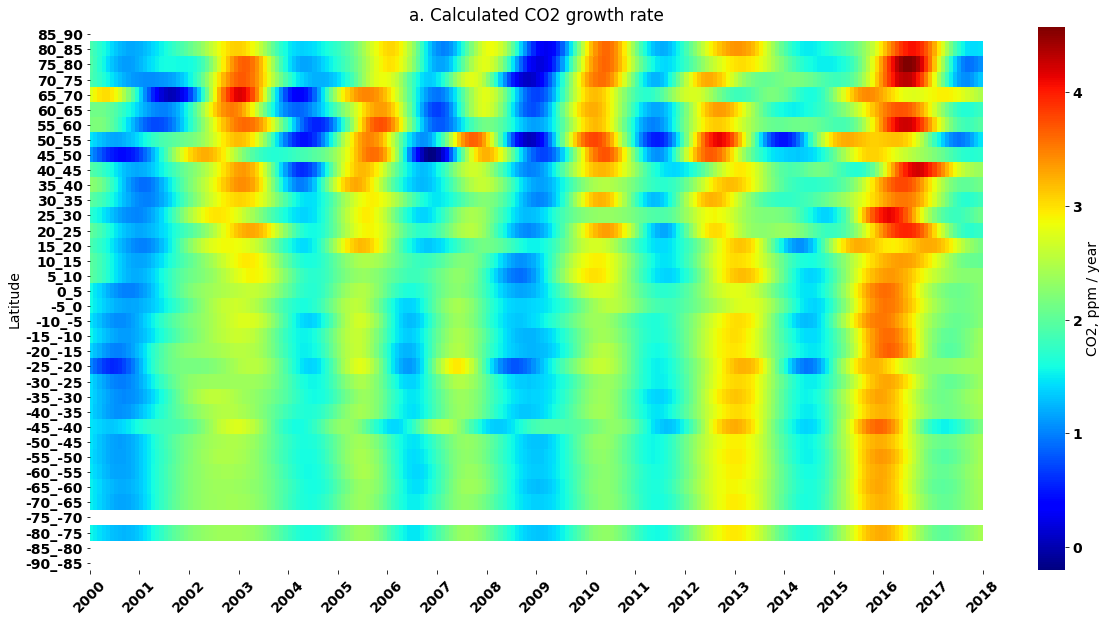

In [15]:
# Arrange dataframe for plot
df_co2rate_cal = pd.read_csv(IN_PATH + "df_co2rate_cal_ctracker_model_129p.csv")

zonal_deg = 5
lat_range = range(-90,90,zonal_deg)
df_zonal_cal = pd.DataFrame() 

for i in lat_range:
    lat_id = (i < df_co2rate_cal.lat) & (df_co2rate_cal.lat<= i+zonal_deg)
    temp_cal = df_co2rate_cal.loc[lat_id,:]
    df_zonal_cal = pd.concat([df_zonal_cal,  pd.DataFrame(temp_cal.iloc[:,4:].mean()).T] )

df_zonal_cal["lat"] = [str(i) + "_" + str(i+zonal_deg)  for i in lat_range]
cols_new = df_zonal_cal.columns.to_list()
cols_new = cols_new[-1:] + cols_new[:-1]
df_zonal_cal = df_zonal_cal.loc[:,cols_new]
df_zonal_cal = df_zonal_cal.iloc[::-1] 
df_zonal_cal = df_zonal_cal.set_index(["lat"])

# plot
xticks = [i for i in range(0, df_zonal_cal.shape[1]+12, 12)]
xticklabels = [i for i in range(2000,2019)]

# sns.set(font_scale=1.4)
fig = plt.figure(figsize=[20,10])
# ax1 = plt.axis()
g = sns.heatmap(df_zonal_cal, cmap=plt.get_cmap("jet"), cbar_kws={'label': 'CO2, ppm / year'})
g.set_ylabel("Latitude")
g.set_xticks(xticks)
g.set_xticklabels(xticklabels,rotation=45) 
g.set_title("a. Calculated CO2 growth rate");


#BIR statation at (8.3, 58)